## Import libaries

In [1]:
import os

if os.getcwd().endswith('/notebooks'):
    os.chdir('..')

assert os.path.exists('./src'), f"[ERROR] The path src not detected in the current directory '{os.getcwd()}'."

print(f'[INFO] Current Directory: "{os.getcwd()}".')

if not os.path.exists("images"):
    os.mkdir("images")

[INFO] Current Directory: "/home/ferdi/topic-modeling-advancements".


In [2]:
%load_ext autoreload
%autoreload 2
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer

from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.dataset.dataset import Dataset
from octis.models.LDA import LDA

import time
import pandas as pd
import numpy as np
import zlib
import pickle as pkl
import sklearn
import pandas as pd
from tabulate import tabulate
import kaleido

## Preencode data with embeddings
from sentence_transformers import SentenceTransformer
## Load data with datalaoder from src
from src.utils import load_documents
from src.bertopic_runner import Trainer
from umap import UMAP
from hdbscan import HDBSCAN

## Parametric run: BERTopic

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/ferdi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ferdi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ferdi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

If we set hdbscan_args to None, Kmeans is used for clustering. That way we can enforce having no noise clusters/documents.
As a consequence we also have no assignment scores since KMeans does not produce any (set as default to 1).

In [4]:
configs = {
    'dataset': 'crisis_12',
    'preprocessing_funcs': [
        'to_lowercase',
        'standardize_accented_chars',
        'remove_url',
        'expand_contractions',
        'remove_mentions',
        'remove_hashtags',
        'remove_new_lines',
        'keep_only_alphabet',
        # 'remove_extra_spaces',
        'remove_english_stop_words',
        'lemmatize_noun',
        #'correct_typo'
    ],
    'algorithm': 'bertopic',
    'algorithm_args': {
        "embedding_model": "all-MiniLM-L6-v2",
        "top_n_words": 10,
        "n_gram_range_tuple": (1, 1),
        ## Both the same as below
        "min_docs_per_topic": 15,
        "number_topics": 4,
         ## Assign almost all docs to a topic
         #"no_noise": True,
         #"prob_threshold": 0.01,
         ## Setting min_samples to reduce #docs classified as noise/in topic -1
        "cluster_model": "hdbscan", #"hdbscan"or "kmeans" then we do not need hdbscan_args; if used are ignored
        "hdbscan_args": {
                    "min_cluster_size": 15,
                    "metric":'euclidean',
                    "cluster_selection_method": 'eom',
                    "prediction_data": True,
                    #"min_samples": 15
         },    
        "umap_args": {
                    "n_neighbors": 15,
                    "n_components": 5,
                    "min_dist": 0.0,
                    "metric": 'cosine',
                    "low_memory": False,
                    "random_state": 42
        }
    }
}

In [5]:
##Maybe parallelism disable?
#import os
#os.environ["TOKENIZERS_PARALLELISM"] = "false"

from src import preprocessor
from src.utils import load_documents

docs, labels = load_documents(dataset=configs['dataset'])

if 'preprocessing_funcs' in configs:
    docs = preprocessor.run(data=docs, prep_functions=configs['preprocessing_funcs'])
    
algorithm_args = configs['algorithm_args']
algorithm_args.update(data_name=configs['dataset'],docs=docs,labels=labels)
print(f'Running with {algorithm_args["number_topics"]} topics')

if configs['algorithm'] == 'bertopic':
    # Encode data with embedding model
    model = SentenceTransformer(algorithm_args['embedding_model'])
    embeddings = model.encode(docs, show_progress_bar=True)
    
    trainer = Trainer(dataset = configs['dataset'],
                      model_name = configs['algorithm'],
                      params = algorithm_args,
                      topk = algorithm_args["top_n_words"],
                      bt_embeddings = embeddings,
                      )
    
    model, df_output_doc_topic, df_output_topic_word = trainer.train()
    
    from src.evaluator import compute_topic_scores
    df_output_topic_word = compute_topic_scores(df_output_doc_topic, df_output_topic_word)

[INFO] Available Preprocessing Functions in the Module:['to_lowercase', 'standardize_accented_chars', 'remove_url', 'expand_missing_delimiter', 'remove_mentions', 'remove_hashtags', 'keep_only_alphabet', 'remove_new_lines', 'remove_extra_spaces', 'remove_html_tags', 'expand_contractions', 'remove_english_stop_words', 'lemmatize', 'lemmatize_verb', 'lemmatize_noun', 'lemmatize_adjective', 'correct_typo']
[INFO] Preprocessing starting..
[INFO] These string preprocessing methods will be applied to the data in order:
(  'to_lowercase',
   'standardize_accented_chars',
   'remove_url',
   'remove_mentions',
   'remove_hashtags',
   'remove_new_lines',
   'keep_only_alphabet')
[INFO] Then, these tokenized preprocessing methods will be applied to the data in order:
(  '__tokenize',
   'expand_contractions',
   'remove_english_stop_words',
   'lemmatize_noun',
   '__glue')
[INFO] Preprocessing completed in 2.41 seconds..
Running with 4 topics


Batches:   0%|          | 0/250 [00:00<?, ?it/s]

2022-07-20 17:28:20,326 - BERTopic - Reduced dimensionality
2022-07-20 17:28:20,661 - BERTopic - Clustered reduced embeddings
2022-07-20 17:28:21,962 - BERTopic - Reduced number of topics from 81 to 5


In [13]:
## Labels per topic
from src import visualizer
visualizer.visualize_labels_per_topic(df_output_doc_topic=df_output_doc_topic,
                               df_output_topic_word=df_output_topic_word,top_n_topics=10)

In [14]:
visualizer.visualize_heatmap(
    model=model,
    df_output_doc_topic=df_output_doc_topic,
    df_output_topic_word=df_output_topic_word,
    topics= None,
    top_n_topics = None,
    n_clusters = None, # Unknown for now
    width = 1000,
    height = 1000
)

[INFO] UMAP Arguments for Visualization:{'n_neighbors': 15, 'n_components': 2, 'min_dist': 0.0, 'metric': 'cosine', 'low_memory': False}
[INFO] UMAP Model is being fitted..
[INFO] UMAP Model successfully fitted.


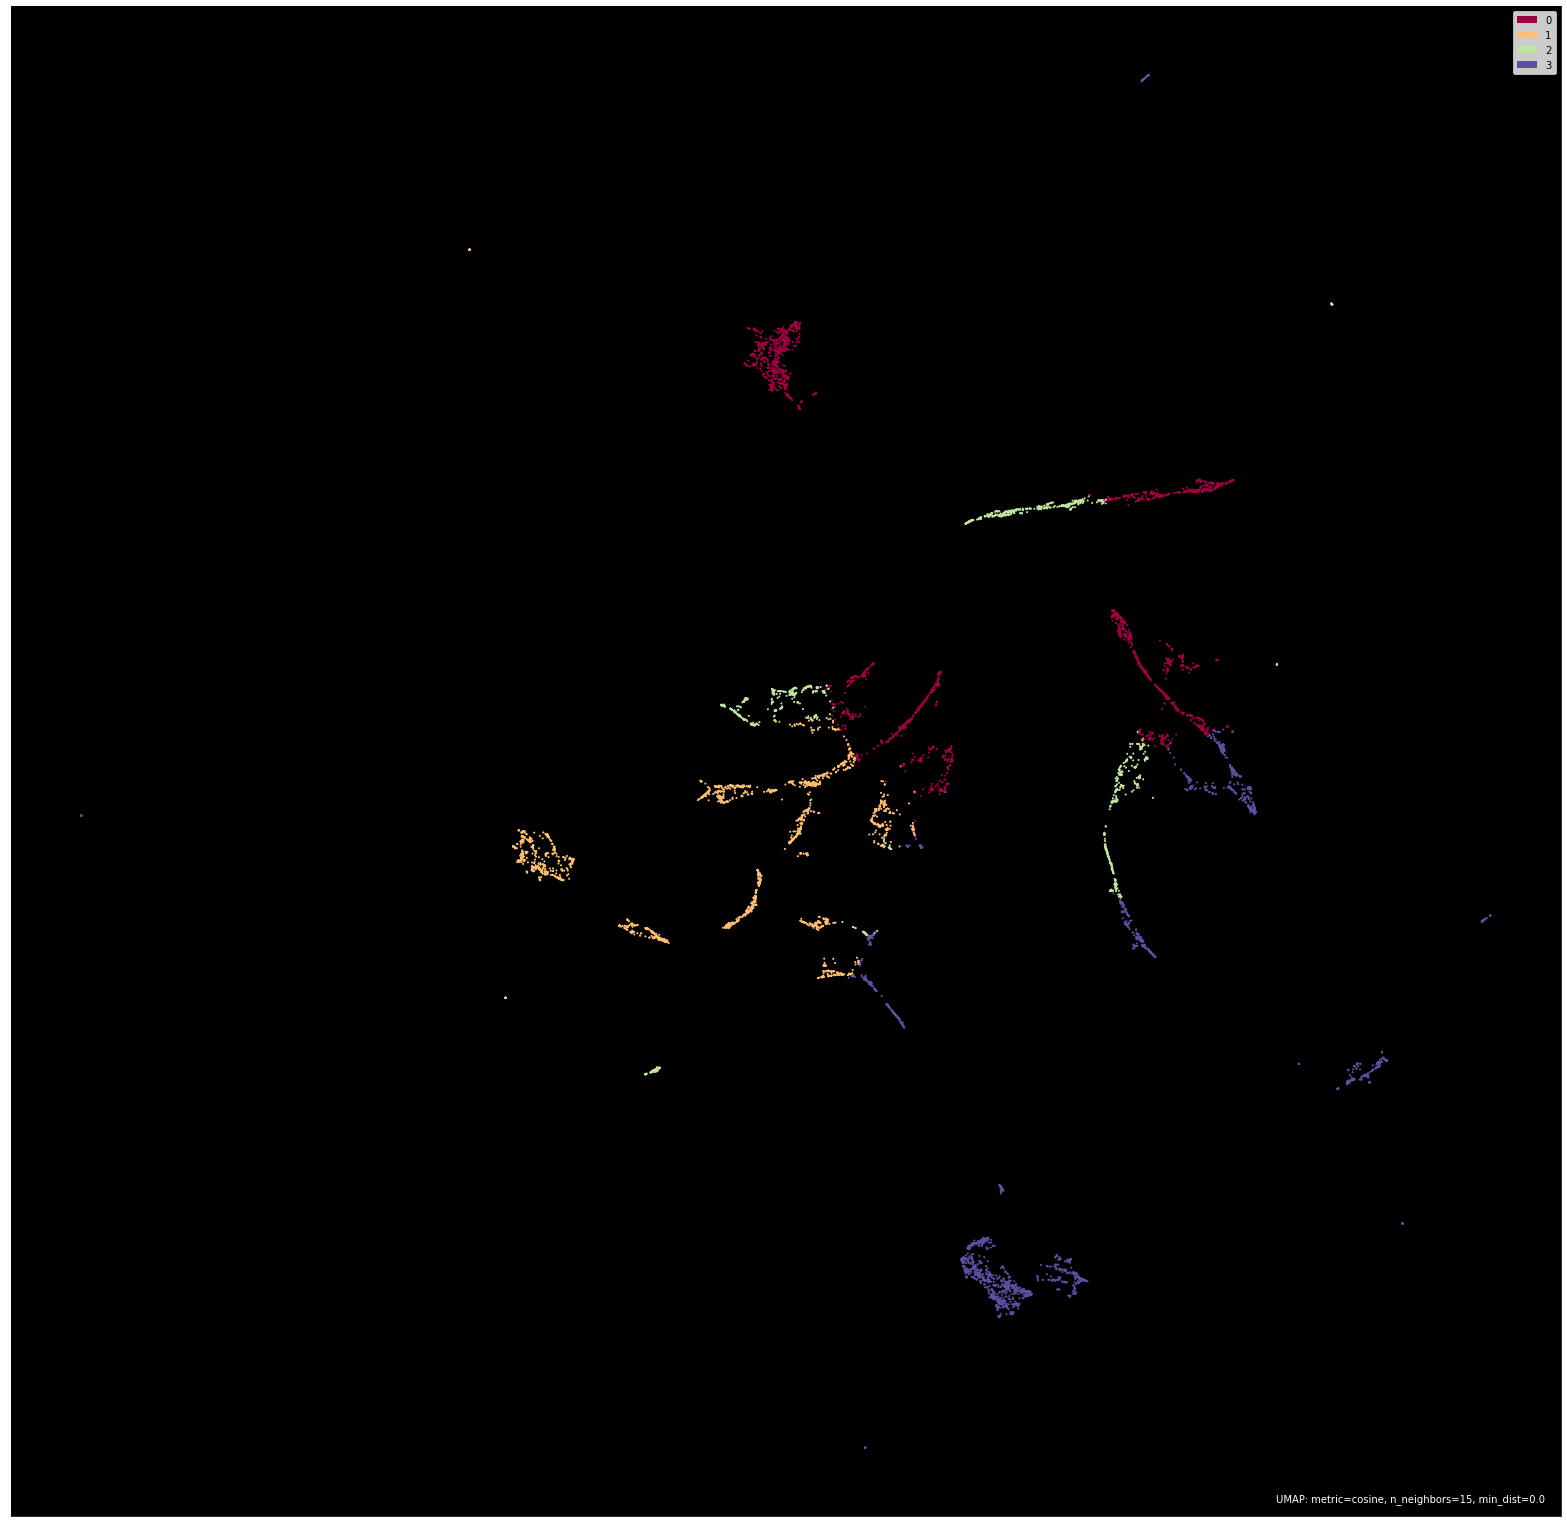

In [15]:
_ = visualizer.draw_umap2d_scatter_plot(model=model, df_output_topic_word=df_output_topic_word, df_output_doc_topic= df_output_doc_topic,target_dir= './output/visualization')

In [16]:
visualizer.visualize_barchart(df_output_topic_word=df_output_topic_word,n_words=5)

In [17]:
from src.visualizer import draw_representative_docs
x = draw_representative_docs(df_output_doc_topic,top_n_docs=3)
x

run_id,Document ID,Document,Real Label,Assigned Topic Num,Assignment Score
1658330994,67,mf earthquake,earthquake,0,1
1658330994,4996,security traffic camera record chilling advance canada wildfire reuters,forestfire,0,1
1658330994,4988,breaking image show total devastation california wildfire,forestfire,0,1
1658330994,156,cat looked looked back shrugged went back sleep,earthquake,1,1
1658330994,7140,road access town cut deadly tropical cyclone debbie hammer australia queensland coast,hurricane,1,1
1658330994,7159,hey north queensland get broke cyclone debbie,hurricane,1,1
1658330994,10,listening live podcast recording earthquake quickest way news listen live podcasts,earthquake,2,1
1658330994,5830,wildfire devastate northern southern,forestfire,2,1
1658330994,5247,blue jay create auction wildfire victim blue jay created special auction memorabilia wi,forestfire,2,1
1658330994,0,thereformedcrow nah going to go earthquake,earthquake,3,1


## Parametric Run: LDA-BERT

In [11]:
configs = {
    'dataset': 'crisis_12',
    'preprocessing_funcs': [
        'to_lowercase',
        'standardize_accented_chars',
        'remove_url',
        'expand_contractions',
        'expand_missing_delimiter',
        'remove_mentions',
        'remove_hashtags',
        'remove_new_lines',
        'keep_only_alphabet',
        # 'remove_extra_spaces',
        'remove_english_stop_words',
        'lemmatize_noun',
        #'correct_typo'
    ],
    'algorithm': 'lda-bert',
    'algorithm_args': {
            'embedding_model': "all-MiniLM-L6-v2",
            'number_topics': 4,
            'top_n_words': 10,
            'gamma': 15 ,
            'random_state': 42
    }     
}

In [12]:
from src import preprocessor
from src.utils import load_documents

docs, labels = load_documents(dataset=configs['dataset'])

if 'preprocessing_funcs' in configs:
    docs = preprocessor.run(data=docs, prep_functions=configs['preprocessing_funcs'])
    
algorithm_args = configs['algorithm_args']
algorithm_args.update(data_name=configs['dataset'],docs=docs,labels=labels)
print(f'Running with {algorithm_args["number_topics"]} topics')

if configs['algorithm'] == 'lda-bert':
    # Encode data with embedding model
    model = SentenceTransformer(algorithm_args['embedding_model'])
    embeddings = model.encode(docs, show_progress_bar=True)
    
    trainer = Trainer(dataset = configs['dataset'],
                      model_name = configs['algorithm'],
                      params = algorithm_args,
                      topk = algorithm_args["top_n_words"],
                      bt_embeddings = embeddings,
                      )
    
    model, df_output_doc_topic, df_output_topic_word = trainer.train()
    
    from src.evaluator import compute_topic_scores
    df_output_topic_word = compute_topic_scores(df_output_doc_topic, df_output_topic_word)

[INFO] Available Preprocessing Functions in the Module:['to_lowercase', 'standardize_accented_chars', 'remove_url', 'expand_missing_delimiter', 'remove_mentions', 'remove_hashtags', 'keep_only_alphabet', 'remove_new_lines', 'remove_extra_spaces', 'remove_html_tags', 'expand_contractions', 'remove_english_stop_words', 'lemmatize', 'lemmatize_verb', 'lemmatize_noun', 'lemmatize_adjective', 'correct_typo']
[INFO] Preprocessing starting..
[INFO] These string preprocessing methods will be applied to the data in order:
(  'to_lowercase',
   'standardize_accented_chars',
   'remove_url',
   'expand_missing_delimiter',
   'remove_mentions',
   'remove_hashtags',
   'remove_new_lines',
   'keep_only_alphabet')
[INFO] Then, these tokenized preprocessing methods will be applied to the data in order:
(  '__tokenize',
   'expand_contractions',
   'remove_english_stop_words',
   'lemmatize_noun',
   '__glue')
huggingface/tokenizers: The current process just got forked, after parallelism has already 

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Tokenizing raw texts ...
Tokenizing raw texts. Done!
Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...
Getting vector representations for BERT. Done!
Fitting Autoencoder ...


2022-07-20 17:30:24.312758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-20 17:30:24.342854: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-07-20 17:30:24.342876: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-07-20 17:30:24.344069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

Fitting Autoencoder Done!
250/250 [==============================] - 0s 1ms/step
Clustering embeddings. Done!


In [54]:
df_output_topic_word

,run_id,method,method_specific_params,dataset,num_given_topics,reduced,topic_num,topic_size,topic_words,word_scores,num_detected_topics,num_final_topics,duration_secs,diversity_unique,diversity_inv_rbo,coherence_npmi,coherence_v,rand_index
0,1658324401,lda-bert,"{'embedding_model': 'all-MiniLM-L6-v2', 'numbe...",crisis_17,10,False,0,3179,"[flood, water, rescue, flooding, road, cross, ...","[0.022132138181085708, 0.013269211400946722, 0...",10,10,498.477412,0.61,0.852801,0.036869,0.397516,0.786694
1,1658324401,lda-bert,"{'embedding_model': 'all-MiniLM-L6-v2', 'numbe...",crisis_17,10,False,1,3899,"[shelter, new, hurricane, rt, update, amp, tsu...","[0.012545110843787592, 0.011428080426190068, 0...",10,10,498.477412,0.61,0.852801,0.036869,0.397516,0.786694
2,1658324401,lda-bert,"{'embedding_model': 'all-MiniLM-L6-v2', 'numbe...",crisis_17,10,False,2,8417,"[hurricane, storm, flooding, damage, wind, dor...","[0.02720473125761002, 0.017342146460253956, 0....",10,10,498.477412,0.61,0.852801,0.036869,0.397516,0.786694
3,1658324401,lda-bert,"{'embedding_model': 'all-MiniLM-L6-v2', 'numbe...",crisis_17,10,False,3,8568,"[flood, kerala, death, people, toll, rt, relie...","[0.025392576730906495, 0.023010349750178443, 0...",10,10,498.477412,0.61,0.852801,0.036869,0.397516,0.786694
4,1658324401,lda-bert,"{'embedding_model': 'all-MiniLM-L6-v2', 'numbe...",crisis_17,10,False,4,4839,"[california, fire, wildfire, home, destroyed, ...","[0.041531251069070504, 0.037066812630426604, 0...",10,10,498.477412,0.61,0.852801,0.036869,0.397516,0.786694
5,1658324401,lda-bert,"{'embedding_model': 'all-MiniLM-L6-v2', 'numbe...",crisis_17,10,False,5,11828,"[amp, affected, people, prayer, thought, rt, h...","[0.01958651399491094, 0.016755725190839694, 0....",10,10,498.477412,0.61,0.852801,0.036869,0.397516,0.786694
6,1658324401,lda-bert,"{'embedding_model': 'all-MiniLM-L6-v2', 'numbe...",crisis_17,10,False,6,4694,"[earthquake, rt, mexico, hurricane, harvey, pe...","[0.04409662993868425, 0.039302014660458254, 0....",10,10,498.477412,0.61,0.852801,0.036869,0.397516,0.786694
7,1658324401,lda-bert,"{'embedding_model': 'all-MiniLM-L6-v2', 'numbe...",crisis_17,10,False,7,12310,"[help, relief, rt, please, donate, need, victi...","[0.040284255594626804, 0.02481351243986052, 0....",10,10,498.477412,0.61,0.852801,0.036869,0.397516,0.786694
8,1658324401,lda-bert,"{'embedding_model': 'all-MiniLM-L6-v2', 'numbe...",crisis_17,10,False,8,8296,"[hurricane, puerto, rico, irma, rt, maria, eva...","[0.06543405695887881, 0.02310551360053029, 0.0...",10,10,498.477412,0.61,0.852801,0.036869,0.397516,0.786694
9,1658324401,lda-bert,"{'embedding_model': 'all-MiniLM-L6-v2', 'numbe...",crisis_17,10,False,9,10454,"[not, people, hurricane, help, water, flood, a...","[0.02024887901068655, 0.009937069533642602, 0....",10,10,498.477412,0.61,0.852801,0.036869,0.397516,0.786694


In [20]:
df_output_doc_topic+

,run_id,Document ID,Document,Real Label,Assigned Topic Num,Assignment Score
0,1658231276,0,thereformedcrow nah going go earthquake,earthquake,2,1
1,1658231276,1,think earthquake,earthquake,2,1
2,1658231276,2,uhh else felt earthquake though,earthquake,2,1
3,1658231276,3,bay area nice size earthquake,earthquake,0,1
4,1658231276,4,thought dad farting turn earthquake,earthquake,2,1
...,...,...,...,...,...,...
391,1658231276,391,people keep asking good safe live cyclone debb...,hurricane,0,1
392,1658231276,392,ayyeeee work got cancelled flood thank cyclone...,hurricane,1,1
393,1658231276,393,jetstarairways helpful need change flight due ...,hurricane,0,1
394,1658231276,394,getting hit ex tropical cyclone named debbie r...,hurricane,0,1
